In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
# 20 sec

In [2]:
from concurrent.futures import ThreadPoolExecutor

In [3]:
import sqlite3 as sql
import pandas as pd
import pyarrow.parquet as pq

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# 10 sec

In [6]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [7]:
NuMu_PeV_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22012/"

In [8]:
truth_14_parquet = NuMu_PeV_root + "truth_14.parquet"

PMTfied_14 = NuMu_PeV_root + "14/"

PMTfied_14_1 = PMTfied_14 + "PMTfied_1.parquet"
PMTfied_14_2 = PMTfied_14 + "PMTfied_2.parquet"

In [9]:
def get_files_in_dir(directory, extension='.parquet'):
    return [f for f in os.listdir(directory) if f.endswith(extension)]
def get_subdir_in_dir(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

In [10]:
get_subdir_in_dir(NuMu_PeV_root)

['23',
 '4',
 '11',
 '16',
 '3',
 '9',
 '24',
 '20',
 '18',
 '12',
 '7',
 '15',
 '27',
 '17',
 '8',
 '2',
 '25',
 '22',
 '5',
 '10',
 '1',
 '14',
 '26',
 '21',
 '13',
 '19',
 '6']

In [11]:
def convertParquetToDF(file:str) -> pd.DataFrame:
    table = pq.read_table(file)
    df = table.to_pandas()
    return df

In [12]:
convertParquetToDF(truth_14_parquet)
# 20 sec
# 29386 rows × 11 columns

,event_no,subdirectory_no,db_file_no,shard_index,file_no,N_doms,offset,energy,azimuth,zenith,pid
0,378999,22012,14,1,1,55,55,1.803880e+06,5.608516,2.009270,14.0
1,379000,22012,14,1,1,316,371,3.485332e+07,0.894426,0.712727,14.0
2,379001,22012,14,1,1,206,577,1.333500e+07,6.219020,1.456280,-14.0
3,379002,22012,14,1,1,596,1173,3.660456e+07,2.972698,1.358138,14.0
4,379003,22012,14,1,1,79,1252,8.019223e+06,3.407122,1.611888,14.0
...,...,...,...,...,...,...,...,...,...,...,...
29266,408265,22012,14,15,15,705,454073,1.621185e+07,1.636867,2.092956,-14.0
29267,408266,22012,14,15,15,21,454094,1.603218e+07,2.044639,1.848888,14.0
29268,408267,22012,14,15,15,243,454337,1.374423e+07,2.931348,1.090616,-14.0
29269,408268,22012,14,15,15,496,454833,3.966575e+06,3.410665,0.597132,14.0


In [13]:
convertParquetToDF(PMTfied_14_1)
# 16 sec
# 695403 rows × 24 columns

,event_no,dom_x,dom_y,dom_z,dom_x_rel,dom_y_rel,dom_z_rel,pmt_area,rde,saturation_status,...,Qtotal,hlc1,hlc2,hlc3,t1,t2,t3,T10,T50,sigmaT
0,378999,405.829987,-306.380005,478.109985,0.000000e+00,0.000000e+00,0.000000,0.0444,1.00,-1,...,0.725,0,-1,-1,19927.0,-1.0,-1.0,-1.0,-1.0,9394.149414
1,378999,326.850006,-209.070007,464.380005,5.684342e-14,0.000000e+00,20.529278,0.0444,1.00,-1,...,0.825,1,-1,-1,21107.0,-1.0,-1.0,-1.0,-1.0,9950.406250
2,378999,326.850006,-209.070007,447.359985,5.684342e-14,0.000000e+00,3.509279,0.0444,1.00,-1,...,0.275,1,-1,-1,20505.0,-1.0,-1.0,-1.0,-1.0,9666.621094
3,378999,326.850006,-209.070007,430.339996,5.684342e-14,0.000000e+00,-13.510721,0.0444,1.00,-1,...,1.325,1,-1,-1,19843.0,-1.0,-1.0,-1.0,-1.0,9354.551758
4,378999,443.600006,-194.160004,516.669983,-8.979855e-02,-1.166529e-01,60.176601,0.0444,1.00,-1,...,0.875,1,-1,-1,19571.0,-1.0,-1.0,-1.0,-1.0,9226.329102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722172,380998,-10.970000,6.720000,-430.329987,-1.776357e-15,2.664535e-15,-80.524109,0.0444,1.35,0,...,2.750,0,0,-1,14271.0,17633.0,-1.0,0.0,3362.0,7644.540527
722173,380998,-10.970000,6.720000,-451.359985,-1.776357e-15,2.664535e-15,-101.554108,0.0444,1.35,0,...,3.025,1,1,1,14118.0,14241.0,14287.0,0.0,123.0,71.341118
722174,380998,-10.970000,6.720000,-458.369995,-1.776357e-15,2.664535e-15,-108.564110,0.0444,1.35,0,...,2.150,1,1,-1,13026.0,14562.0,-1.0,0.0,0.0,6533.188965
722175,380998,-10.970000,6.720000,-465.380005,-1.776357e-15,2.664535e-15,-115.574112,0.0444,1.35,0,...,1.775,1,-1,-1,13728.0,-1.0,-1.0,-1.0,-1.0,6471.912598


In [14]:
class PMTfiedDataset_part(Dataset):
    """
    This dataset corresponds to a PMTfied pulsemap data from a single .db file.
    e.g., merged_part_1.db, merged_part_2.db, ...
    """
    def __init__(self, root_subdir: str, subsubdir: str, isVerbose: bool = False, max_n_doms: int = None):
        print("Initializing PMTfiedDataset_part...")
        self.root_subdir = root_subdir
        self.subsubdir = subsubdir
        self.isVerbose = isVerbose

        feature_dir = os.path.join(self.root_subdir, self.subsubdir)

        # Load feature files and truth data
        self.feature_files = self._prepare_feature_file(feature_dir)
        self.truth_file = os.path.join(self.root_subdir, f"truth_{self.subsubdir}.parquet")
        self.truth_data = pq.read_table(self.truth_file).to_pandas()

        # Determine maximum N_doms if not provided
        self.max_n_doms = max_n_doms or self.truth_data["N_doms"].max()

        if isVerbose:
            print("Calling _show_info...")
            self._show_info()

    def _prepare_feature_file(self, feature_dir):
        """Map feature file names to their paths."""
        if not os.path.exists(feature_dir):
            raise FileNotFoundError(f"Feature directory not found: {feature_dir}")

        feature_files = {}
        files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith(".parquet")]
        for file in files:
            file_name = os.path.basename(file)
            feature_files[file_name] = file
        return feature_files

    def __len__(self):
        """Override Dataset.__len__: Return the number of samples (truth data rows)."""
        return len(self.truth_data)

    def __getitem__(self, idx):
        """
        Override Dataset.__getitem__: Retrieve a single data sample by index.
        Args:
            idx (int): Index of truth, i.e., the index for event_no.
        Returns:
            dict: A dictionary with keys 'features' and 'truth', both as tensors.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the truth data for the given index
        truth_row = self.truth_data.iloc[idx]
        event_no = truth_row["event_no"]
        file_no = truth_row["file_no"]
        offset = truth_row["offset"]
        n_doms = truth_row["N_doms"]

        # Load corresponding feature rows and pad to max_n_doms
        features = self._load_feature_rows(file_no, offset, n_doms)
        features_padded = np.zeros((self.max_n_doms, features.shape[1]), dtype=np.float32)
        features_padded[:features.shape[0], :] = features

        # Extract the target column (e.g., zenith)
        target = truth_row["zenith"]

        # Prepare the sample
        features_tensor = torch.tensor(features_padded, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return {
            "features": features_tensor,
            "truth": target_tensor,
        }

    def _load_feature_rows(self, file_no, offset, n_rows):
        """Load rows corresponding to the file number, offset, and number of rows."""
        file_key = f"PMTfied_{int(file_no)}.parquet"
        if file_key not in self.feature_files:
            raise FileNotFoundError(f"Feature file {file_key} not found.")
        feature_file = self.feature_files[file_key]

        # Load rows as NumPy array
        table = pq.read_table(feature_file)
        df = table.to_pandas()
        return df.iloc[offset : offset + n_rows].values
    
    def _show_info(self):
        """Print overall statistics of the dataset for debugging."""
        print(f"------------- Part Dataset Statistics (Subsubdir: {self.subsubdir}) -------------")
        num_events = len(self.truth_data)
        print(f"Total events (rows in truth file): {num_events:,}")
        
        num_feature_files = len(self.feature_files)
        print(f"Number of feature files loaded: {num_feature_files}")
        
        self._get_N_dom_stat()
        
        for file_name, file_path in self.feature_files.items():
            table = pq.read_table(file_path)
            df = table.to_pandas()
            print(f"({file_name}) contains {len(df):,} rows")
    
    def _get_N_dom_stat(self):
        self.truth_data["N_doms"] = self.truth_data["N_doms"].astype(int)  # Ensure integer type
        max_n_doms = self.truth_data["N_doms"].max()
        min_n_doms = self.truth_data["N_doms"].min()
        avg_n_doms = self.truth_data["N_doms"].mean()
        print(f"Statistics for N_doms in subsubdir {self.subsubdir}:")
        print(f"  Max N_doms: {max_n_doms}")
        print(f"  Min N_doms: {min_n_doms}")
        print(f"  Avg N_doms: {avg_n_doms:.2f}")


In [15]:
dataset_div = PMTfiedDataset_part(NuMu_PeV_root, "14", isVerbose=True)
#2848

Initializing PMTfiedDataset_part...
Calling _show_info...
------------- Part Dataset Statistics (Subsubdir: 14) -------------
Total events (rows in truth file): 29,271
Number of feature files loaded: 15
Statistics for N_doms in subsubdir 14:
  Max N_doms: 2624
  Min N_doms: 3
  Avg N_doms: 358.98
(PMTfied_12.parquet) contains 707,023 rows


(PMTfied_2.parquet) contains 698,583 rows
(PMTfied_6.parquet) contains 713,758 rows
(PMTfied_3.parquet) contains 719,294 rows
(PMTfied_7.parquet) contains 716,736 rows
(PMTfied_13.parquet) contains 722,312 rows
(PMTfied_1.parquet) contains 722,177 rows
(PMTfied_5.parquet) contains 739,207 rows
(PMTfied_9.parquet) contains 701,478 rows
(PMTfied_11.parquet) contains 715,020 rows
(PMTfied_15.parquet) contains 454,932 rows
(PMTfied_10.parquet) contains 731,564 rows
(PMTfied_14.parquet) contains 694,210 rows
(PMTfied_8.parquet) contains 735,444 rows
(PMTfied_4.parquet) contains 736,054 rows


In [19]:
class PMTfiedDataset(Dataset):
    """ 
    This dataset corresponds to all the PMTfied pulsemap parquet files from a subdirectory.
    It wraps multiple PMTfiedDataset_division instances for each subsubdirectory.
    """
    def __init__(self, subdir: str, isVerbose: bool=False):
        """
        Args:
            subdir (str): The subdirectory path containing subsubdirectories 
                with data of the same energy range (e.g., "22010", "22011", "22012", ...).
            isVerbose (bool): Whether to print detailed dataset information.
        """
        self.subdir = subdir
        self.isVerbose = isVerbose

        # Get the list of subsubdirectories in the provided subdir
        self.subsubdirs = self._get_subdir_in_dir()

        # PMTfiedDataset_subsubdir instances for each subsubdirectory
        self.datasets_subsubdir = [
            PMTfiedDataset_part(self.subdir, subsubdir, isVerbose=isVerbose)
            for subsubdir in self.subsubdirs
        ]

        # Compute the cumulative length for indexing across subsubdatasets
        self.cumulative_lengths = self._compute_cumulative_lengths()

        if isVerbose:
            self._show_info()

    def _get_subdir_in_dir(self):
        """Get all subsubdirectories within the main directory."""
        return [name for name in os.listdir(self.subdir) if os.path.isdir(os.path.join(self.subdir, name))]

    def _compute_cumulative_lengths(self):
        """
        Compute cumulative lengths of all subsubdatasets for global indexing.
        This allows treating all subsubdatasets as a single dataset.
        """
        lengths = [len(dataset) for dataset in self.datasets_subsubdir]
        cumulative_lengths = [0]
        for length in lengths:
            cumulative_lengths.append(cumulative_lengths[-1] + length)
        return cumulative_lengths

    def __len__(self):
        """Override Dataset.__len__: Return the total number of samples across all subsubdatasets."""
        return self.length

    def __getitem__(self, idx):
        """
        Override Dataset.__getitem__:
        Retrieve a single sample based on a global index.
        Args:
            idx (int): Global index across all subsubdatasets.
        Returns:
            dict: A dictionary containing 'features' and 'truth' tensors.
        """
        if torch.is_tensor(idx):
            idx = idx.item()  # Handle tensor index
        
        dataset_idx, local_idx = self._global_to_local_index(idx)
        return self.datasets_subsubdir[dataset_idx][local_idx]
    
    @property
    def length(self):
        if not hasattr(self, "_length"):
            self._length = self.cumulative_lengths[-1]
        return self._length
    
    def _global_to_local_index(self, idx):
        """Convert global index to subdataset index and local index."""
        for dataset_idx, start in enumerate(self.cumulative_lengths[:-1]):
            if start <= idx < self.cumulative_lengths[dataset_idx + 1]:
                local_idx = idx - start
                return dataset_idx, local_idx
        raise IndexError("Index out of range")

    def _show_info(self):
        """Print overall statistics for debugging."""
        print(f"=========== Dataset Statistics (Subdir: {os.path.basename(os.path.normpath(self.subdir))}) ===========")
        
        print(f"Number of subsubdirectories: {len(self.subsubdirs)}")
        total_events = sum(len(dataset) for dataset in self.datasets_subsubdir)
        print(f"Total events (rows in truth files across all subsubdirs): {total_events:,}")
        for i, dataset in enumerate(self.datasets_subsubdir):
            print(f"Subsubdir {dataset.subsubdir} has {len(dataset):,} events")
            
    def plot_statistics(self):
        """
        Generate plots for dataset statistics:
        (1) Histogram of the number of events per subsubdirectory (parquet file).
        (2) Histogram of N_doms across all events.
        """
        # Collect statistics for num_events and N_doms
        num_events_per_subsubdir = np.array([len(dataset.truth_data) for dataset in self.datasets_subsubdir])
        subsubdir_names = [dataset.subsubdir for dataset in self.datasets_subsubdir]  # Get subsubdirectory names
        all_n_doms = np.concatenate([dataset.truth_data["N_doms"].values for dataset in self.datasets_subsubdir])

        # Plot 1: Bar chart of number of events per subsubdirectory
        fig, ax1 = plt.subplots(figsize=(11, 7))
        ax1.bar(subsubdir_names, num_events_per_subsubdir, color=getColour(6), alpha=0.8, edgecolor="black")
        ax1.set_title(f"Number of Events per Subsubdirectory(total events: {np.sum(num_events_per_subsubdir):,})")
        ax1.set_xlabel("Subsubdirectory (File Numbers)")
        ax1.set_ylabel("Number of Events")
        ax1.set_xticks(subsubdir_names)
        ax1.set_xticklabels(subsubdir_names, rotation=45, ha="right", fontsize=9)
        
        # add value labels on top of the bars
        for i, v in enumerate(num_events_per_subsubdir):
            ax1.text(i, v + 100, str(v), ha="center", va="bottom", fontsize=8)
        
        # d1 = {
        #     "Total Subdirectories": len(subsubdir_names),
        #     "Total Events": np.sum(num_events_per_subsubdir),
        #     "µ": np.mean(num_events_per_subsubdir),
        #     "median": np.median(num_events_per_subsubdir)}
        # add_text_to_ax(0.02, 0.95, nice_string_output(d1), ax1, fontsize=12)
        plt.tight_layout()
        plt.show()

        # Plot 2: Histogram of N_doms across all events
        fig, ax2 = plt.subplots(figsize=(11, 7))
        Nbins_dom, binwidth_dom, bins_dom, counts_dom, bin_centers_dom  = getHistoParam(all_n_doms, binwidth=100)
        ax2.hist(all_n_doms, bins=bins_dom, alpha=0.75, histtype='step')
        ax2.set_title(f"Distribution of N_doms per event")
        ax2.set_xlabel("N_doms")
        ax2.set_ylabel("Frequency")
        d2 = {
            "Nbins": Nbins_dom,
            "binwidth": binwidth_dom,
            "min": np.min(all_n_doms),
            "max": np.max(all_n_doms),
            "mean": np.mean(all_n_doms),
            "median": f"{np.median(all_n_doms):n}",}
        add_text_to_ax(0.5, 0.75, nice_string_output(d2), ax2, fontsize=12)
        plt.show()


In [20]:
dataset = PMTfiedDataset(NuMu_PeV_root, isVerbose=False)

Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...
Initializing PMTfiedDataset_part...


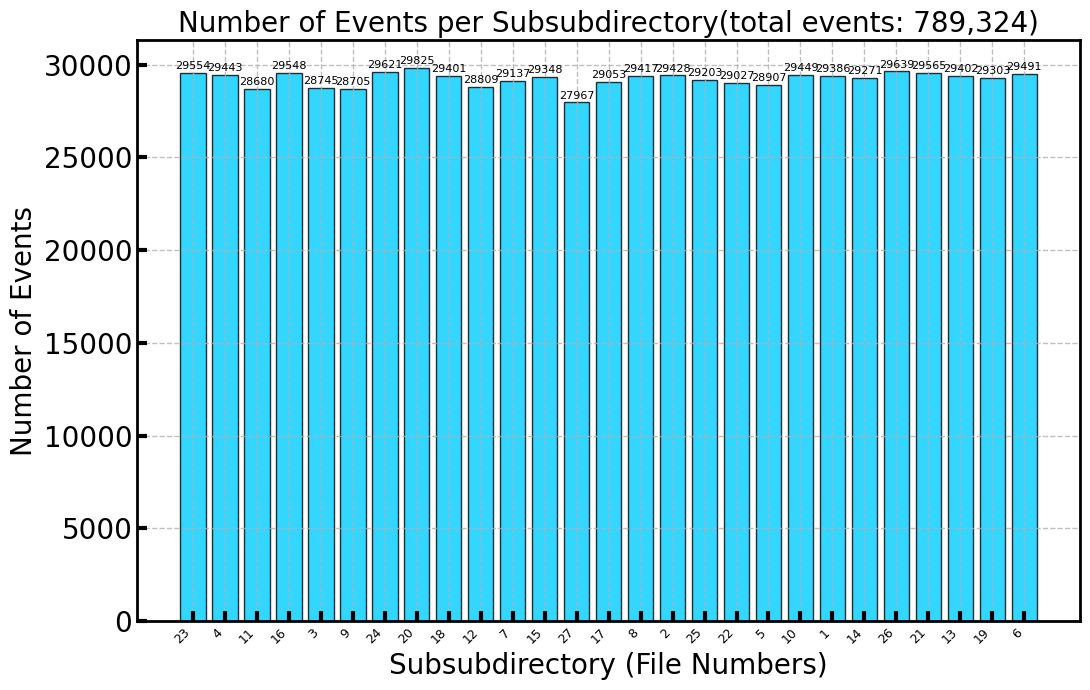

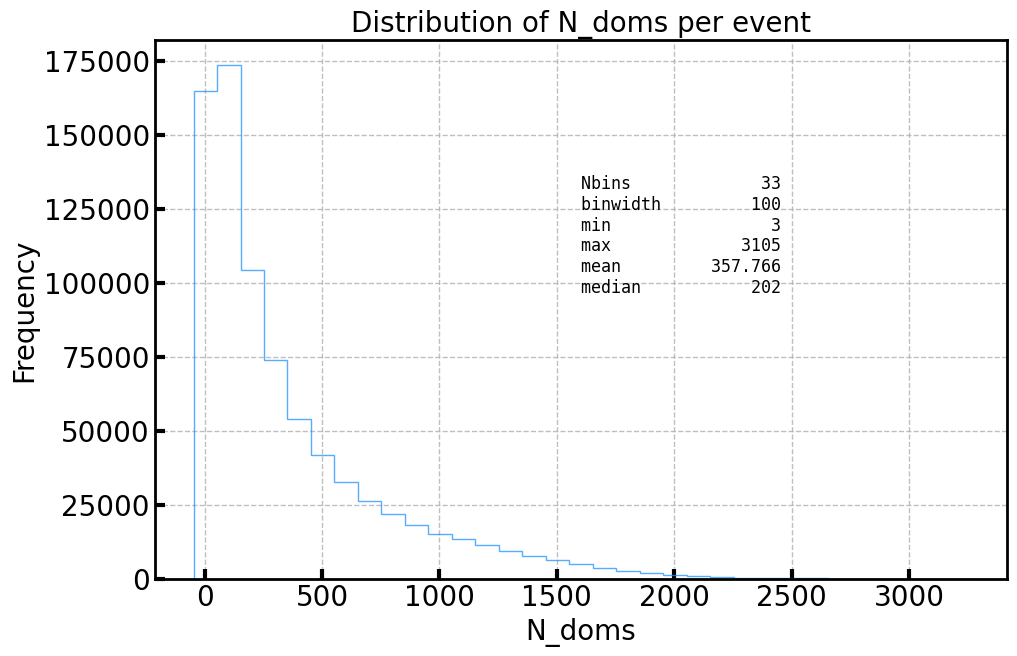

In [21]:
dataset.plot_statistics()

In [ ]:
class PMTfiedDataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 32, num_workers: int = 4, isVerbose: bool = False):
        """
        data_dir (str): The subdirectory name (e.g., "22010", "22011", "22012", ...)
        batch_size (int): Batch size for training and validation.
        num_workers (int): Number of workers for data loading.
        isVerbose (bool): Whether to print detailed dataset information.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.isVerbose = isVerbose

    def setup(self, stage=None):
        self.full_dataset = PMTfiedDataset(self.data_dir, isVerbose=self.isVerbose)
        
        train_size = int(0.8 * len(self.full_dataset))
        val_size = int(0.1 * len(self.full_dataset))
        test_size = len(self.full_dataset) - train_size - val_size
        
        # a seed for reproducibility
        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            self.full_dataset, [train_size, val_size, test_size], generator=generator
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)


In [ ]:
data_module = PMTfiedDataModule(NuMu_PeV_root, batch_size=32, num_workers=4, isVerbose=True)
data_module.setup()
trainDL = data_module.train_dataloader()

------------- Division Dataset Statistics (Subsubdir: 23) -------------
Total events (rows in truth file): 29,554
Number of feature files loaded: 15
Statistics for N_doms in subsubdir 23:
  Max N_doms: 2722
  Min N_doms: 4
  Avg N_doms: 354.99
(PMTfied_13.parquet) contains 701,854 rows
(PMTfied_6.parquet) contains 725,131 rows
(PMTfied_2.parquet) contains 719,509 rows
(PMTfied_7.parquet) contains 711,909 rows
(PMTfied_3.parquet) contains 718,078 rows
(PMTfied_12.parquet) contains 701,413 rows
(PMTfied_9.parquet) contains 700,415 rows
(PMTfied_5.parquet) contains 742,231 rows
(PMTfied_1.parquet) contains 704,522 rows
(PMTfied_10.parquet) contains 701,689 rows
(PMTfied_14.parquet) contains 724,191 rows
(PMTfied_11.parquet) contains 674,964 rows
(PMTfied_15.parquet) contains 559,015 rows
(PMTfied_4.parquet) contains 715,545 rows
(PMTfied_8.parquet) contains 690,775 rows
------------- Division Dataset Statistics (Subsubdir: 4) -------------
Total events (rows in truth file): 29,443
Number 

In [ ]:
for batch in trainDL:
    features = batch["features"]
    truth = batch["truth"]
    print(features.shape, truth.shape)
    break

Features shape: torch.Size([173, 24]), Truth shape: torch.Size([11])Features shape: torch.Size([29, 24]), Truth shape: torch.Size([11])Features shape: torch.Size([74, 24]), Truth shape: torch.Size([11])Features shape: torch.Size([545, 24]), Truth shape: torch.Size([11])



Features shape: torch.Size([100, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([132, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([317, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([303, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([35, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([211, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([523, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([168, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([885, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([164, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([209, 24])

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 155, in <dictcomp>
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 214, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [173, 24] at entry 0 and [132, 24] at entry 1


Features shape: torch.Size([109, 24]), Truth shape: torch.Size([11])

Features shape: torch.Size([175, 24]), Truth shape: torch.Size([11])


Features shape: torch.Size([449, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([236, 24]), Truth shape: torch.Size([11])Features shape: torch.Size([145, 24]), Truth shape: torch.Size([11])

Features shape: torch.Size([74, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([610, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([1338, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([495, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([505, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([80, 24]), Truth shape: torch.Size([11])Features shape: torch.Size([784, 24]), Truth shape: torch.Size([11])

Features shape: torch.Size([500, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([113, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([429, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([662, 24]), Truth shape: torch.Size([11])
Features shape: torch.Size([74, 24]

In [73]:
# radian to degree
def rad2deg(rad):
    return rad * 180 / np.pi
print(rad2deg(1))
print(rad2deg(2))

57.29577951308232
114.59155902616465
